<a href="https://colab.research.google.com/github/vasilyryabtsev/futures-price-prediction/blob/dev/ds/twitter/notebooks/ml_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, AutoTokenizer, AutoModelForSequenceClassification
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
from nltk.stem import PorterStemmer
import re

RANDOM_STATE = 42

df = pd.read_csv('https://github.com/vasilyryabtsev/futures-price-prediction/blob/dev/ds/twitter/data/processed.csv?raw=true')

Xtrain, Xtest, ytrain, ytest = train_test_split(df[['text']], df['1_day_after'], test_size=0.2, random_state=RANDOM_STATE)

curves = {}

def add_curve(model, name):
    """
    Построение ROC кривой.
    """
    fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:, 1])
    roc_auc = auc(fpr, tpr)

    curves[name] = {'fpr': fpr,
                    'tpr': tpr,
                    'thresholds': thresholds,
                    'roc_auc': roc_auc}

def print_metrics(model):
    print(f'ROC-AUC train: {roc_auc_score(ytrain, model.predict_proba(Xtrain)[:, 1])}')
    print(f'ROC-AUC test: {roc_auc_score(ytest, model.predict_proba(Xtest)[:, 1])}')
    print('Classification report for test:')
    print(classification_report(ytest, model.predict(Xtest)))

## Текстовые признаки

### Bag Of Words

In [12]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(), 'text')
])

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 15401
ROC-AUC train: 0.9894876421015903
ROC-AUC test: 0.5637237215909091
Classification report for test:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       800
           1       0.56      0.57      0.57       880

    accuracy                           0.54      1680
   macro avg       0.54      0.54      0.54      1680
weighted avg       0.54      0.54      0.54      1680



In [13]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(), 'text')
])

pl = Pipeline([
    ("prepocessing",ct),
    ("pca", PCA(n_components=10)),
    ("classifier", LogisticRegression(max_iter=500, random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 15401
ROC-AUC train: 0.5253883427741364
ROC-AUC test: 0.5397088068181818
Classification report for test:
              precision    recall  f1-score   support

           0       0.53      0.09      0.16       800
           1       0.53      0.93      0.67       880

    accuracy                           0.53      1680
   macro avg       0.53      0.51      0.42      1680
weighted avg       0.53      0.53      0.43      1680



In [14]:
param_grid = {
    "prepocessing__vectorizer__max_features": [50, 500, 1000, None],
    "prepocessing__vectorizer__ngram_range": [(1, 1), (1, 2)],
    "classifier__C": [0.1, 1, 10]
}

gs = GridSearchCV(pl, param_grid, cv=3, scoring="roc_auc", verbose=2, n_jobs=-1)

gs.fit(Xtrain, ytrain)

gs.best_estimator_, gs.best_score_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


(Pipeline(steps=[('prepocessing',
                  ColumnTransformer(transformers=[('vectorizer',
                                                   CountVectorizer(max_features=50,
                                                                   ngram_range=(1,
                                                                                2)),
                                                   'text')])),
                 ('pca', PCA(n_components=10)),
                 ('classifier',
                  LogisticRegression(C=0.1, max_iter=500, random_state=42))]),
 0.5165843530995408)

In [15]:
bow_lr = gs.best_estimator_

add_curve(bow_lr, 'bow_lr')

print_metrics(bow_lr)

ROC-AUC train: 0.5298306529997543
ROC-AUC test: 0.5177791193181818
Classification report for test:
              precision    recall  f1-score   support

           0       0.52      0.09      0.16       800
           1       0.53      0.92      0.67       880

    accuracy                           0.53      1680
   macro avg       0.53      0.51      0.42      1680
weighted avg       0.53      0.53      0.43      1680



In [16]:
score = cross_val_score(bow_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
print(score, score.mean())

[0.49449569 0.52664195 0.52082073 0.50452096 0.51769743] 0.5128353526077524


## Tf-idf

In [17]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(), 'text')
])

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(max_iter=500, random_state=42))
])

pl.fit(Xtrain, ytrain)

pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape

(15401,)

In [18]:
param_grid = {
    "prepocessing__vectorizer__max_features": [50, 500, 1000, None],
    "prepocessing__vectorizer__ngram_range": [(1, 1), (1, 2)],
    "prepocessing__vectorizer__use_idf": [True, False],
    "prepocessing__vectorizer__smooth_idf": [True, False],
    "classifier__C": [0.1, 1, 10],
}

gs = GridSearchCV(pl, param_grid, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

gs.fit(Xtrain, ytrain)

gs.best_estimator_, gs.best_score_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


(Pipeline(steps=[('prepocessing',
                  ColumnTransformer(transformers=[('vectorizer',
                                                   TfidfVectorizer(ngram_range=(1,
                                                                                2)),
                                                   'text')])),
                 ('classifier',
                  LogisticRegression(C=10, max_iter=500, random_state=42))]),
 0.5928314878908232)

In [19]:
tfidf_lr = gs.best_estimator_

add_curve(tfidf_lr, 'tfidf_lr')

print_metrics(tfidf_lr)

ROC-AUC train: 0.9983188576331651
ROC-AUC test: 0.5772904829545454
Classification report for test:
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       800
           1       0.58      0.62      0.60       880

    accuracy                           0.56      1680
   macro avg       0.56      0.56      0.56      1680
weighted avg       0.56      0.56      0.56      1680



In [20]:
score = cross_val_score(tfidf_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
print(score, np.std(score))

[0.57807107 0.60967913 0.60050862 0.60536056 0.57053806] 0.015586057125138256


## [finbert-tone](https://huggingface.co/yiyanghkust/finbert-tone?text=growth+is+strong+and+we+have+plenty+of+liquidity)

In [5]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
vectorizer = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


In [6]:
pos_neg_ans = list(filter(lambda x: x[0] != 'Neutral',
                     zip([res['label'] for res in vectorizer(df['text'].tolist())], df['1_day_after'])))

len(pos_neg_ans) / df['1_day_after'].shape[0] * 100

6.465825196475351

In [8]:
pred_true_ans = list(map(lambda x: (int(x[0] == 'Positive'), x[1]), pos_neg_ans))

print(classification_report([i[1] for i in pred_true_ans], [i[0] for i in pred_true_ans]))

              precision    recall  f1-score   support

           0       0.50      0.12      0.20       243
           1       0.56      0.90      0.69       300

    accuracy                           0.55       543
   macro avg       0.53      0.51      0.44       543
weighted avg       0.53      0.55      0.47       543



## [finbert ProcusAI](https://huggingface.co/ProsusAI/finbert)

### Прогноз "из коробки"

In [7]:
nlp = pipeline("text-classification", model="ProsusAI/finbert")

Device set to use cuda:0


In [7]:
pos_neg_ans = list(filter(lambda x: x[0] != 'neutral',
                     zip([res['label'] for res in nlp(df['text'].tolist())], df['1_day_after'])))

len(pos_neg_ans) / df['1_day_after'].shape[0] * 100

0.21433674684448678

In [8]:
pred_true_ans = list(map(lambda x: (int(x[0] == 'positive'), x[1]), pos_neg_ans))

print(classification_report([i[1] for i in pred_true_ans], [i[0] for i in pred_true_ans]))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Векторизация + логистическая регрессия

In [8]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Выбор устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка токенизатора и модели на GPU
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

# Токенизация
tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Паддинг (чтобы все тексты были одинаковой длины)
max_len = max(len(i) for i in tokenized.values)
padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

# Masking (нужно показать модели, что все нули — это пустое место)
attention_mask = np.where(padded != 0, 1, 0)

# Перенос данных на GPU
input_ids = torch.tensor(padded).to(device)
attention_mask = torch.tensor(attention_mask).to(device)

# Применение модели
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

# Перенос результатов на CPU и преобразование в DataFrame
features = last_hidden_states[0].cpu().numpy()
features_df = pd.DataFrame(features)

# Объединение данных
df_new = pd.concat([features_df, df.drop('text', axis=1)], axis=1)


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.10 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.46 GiB is free. Process 57587 has 12.28 GiB memory in use. Of the allocated memory 12.06 GiB is allocated by PyTorch, and 107.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Токенезация
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Паддинг (чтобы все тексты были одинаковой длины)
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

# Masking (нужно показать модели, что все нули это пустое место)
attention_mask = np.where(padded != 0, 1, 0)
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

# Применение модели
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

features = last_hidden_states[0].numpy()

features_df = pd.DataFrame(features)

df_new = pd.concat([features_df, df.drop('text', axis=1)], axis=1)

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df_new.drop('1_day_after', axis=1)[[0, 1, 2]],
                                                df['1_day_after'],
                                                test_size=0.1,
                                                random_state=RANDOM_STATE)

In [ ]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],          # Регуляризация
    "penalty": ["l2", "l1", "elasticnet"], # Тип регуляризации
    "solver": ["lbfgs", "liblinear", "saga"], # Решатели
    "max_iter": [100, 500, 1000]           # Количество итераций
}

gs = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

gs.fit(Xtrain, ytrain)

gs.best_estimator_, gs.best_score_

In [ ]:
prosus_lr = gs.best_estimator_

add_curve(prosus_lr, 'prosus_lr')

print_metrics(prosus_lr)

In [ ]:
score = cross_val_score(prosus_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
print(score, np.std(score))

## Word2Vec

In [6]:
sent = [row.split() for row in df['text']]

HIDDEN = 100 # каждое слово закодированно числовым вектором длины 100

model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=HIDDEN,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=2)
model.build_vocab(sent, progress_per=10000) # собираем словарь слов
model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

def get_mean_w2v_vector(sentence):
    Sum = 0
    Count = 0

    try:
      words = sentence.split()
    except TypeError:
      words = []

    for w in words:
        if w in model.wv:
            Sum += model.wv[w]
            # Sum += glove_vectors[w]
            Count += 1

    if Count == 0:
        return 0

    return Sum / Count

NewCols = ['col'+str(i) for i in range(HIDDEN)]

Xtrain, Xtest, ytrain, ytest = train_test_split(df['text'].to_frame(), df['1_day_after'], test_size=0.1, random_state=RANDOM_STATE)

Xtrain['vectors'] = Xtrain.map(get_mean_w2v_vector)
Xtest['vectors'] = Xtest.map(get_mean_w2v_vector)

IdxTrain = []

for ix, row in Xtrain.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTrain.append(ix)

IdxTest = []

for ix, row in Xtest.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTest.append(ix)

Xtrain.drop(index=IdxTrain, inplace=True)
Xtest.drop(index=IdxTest, inplace=True)

ytrain = ytrain.drop(index=IdxTrain)
ytest = ytest.drop(index=IdxTest)

Xtrain[NewCols] = pd.DataFrame(Xtrain['vectors'].tolist(), index=Xtrain.index)
Xtest[NewCols] = pd.DataFrame(Xtest['vectors'].tolist(), index=Xtest.index)
Xtrain.drop(['text','vectors'], axis=1, inplace=True)
Xtest.drop(['text','vectors'], axis=1, inplace=True)

<ipython-input-6-f40fb2be7336>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xtrain[NewCols] = pd.DataFrame(Xtrain['vectors'].tolist(), index=Xtrain.index)
<ipython-input-6-f40fb2be7336>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xtrain[NewCols] = pd.DataFrame(Xtrain['vectors'].tolist(), index=Xtrain.index)
<ipython-input-6-f40fb2be7336>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [7]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],          # Регуляризация
    "penalty": ["l2", "l1", "elasticnet"], # Тип регуляризации
    "solver": ["lbfgs", "liblinear", "saga"], # Решатели
    "max_iter": [100, 500, 1000]           # Количество итераций
}

gs = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

gs.fit(Xtrain, ytrain)

gs.best_estimator_, gs.best_score_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
300 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

(LogisticRegression(C=10), 0.5072473771689956)

In [8]:
w2v_lr = gs.best_estimator_

add_curve(w2v_lr, 'w2v_lr')

print_metrics(w2v_lr)

ROC-AUC train: 0.5271362660467553
ROC-AUC test: 0.5012604994195443
Classification report for test:
              precision    recall  f1-score   support

           0       0.51      0.06      0.10       394
           1       0.53      0.95      0.68       446

    accuracy                           0.53       840
   macro avg       0.52      0.50      0.39       840
weighted avg       0.52      0.53      0.41       840



In [9]:
score = cross_val_score(w2v_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
print(score, np.std(score))

[0.52799076 0.51650721 0.49774646 0.48627198 0.50772047] 0.014467142611231915


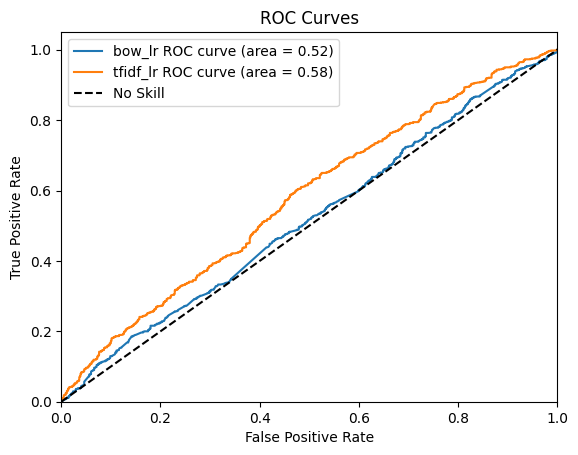

In [21]:
plt.figure()

for model in curves:
    curve = curves[model]
    plt.plot(curve['fpr'], curve['tpr'], label=f"{model} ROC curve (area = {curve['roc_auc']:0.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()